In [1]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

## Scores

In [2]:
def calculate_smape(actual, predicted, epsilon=1e-8):
    absolute_diff = np.abs(actual - predicted)
    sum_absolute = np.abs(actual) + np.abs(predicted)
    smape = np.mean(200 * (absolute_diff / (sum_absolute + epsilon)))

    return smape


def calculate_mase(train_series, actuals, forecasts, m):
    masep = np.mean(np.abs(train_series[m:] - train_series[:-m]))
    mean_absolute_forecast_error = np.mean(np.abs(actuals - forecasts))

    return mean_absolute_forecast_error / masep


def calculate_owa(smape_method, mase_method, smape_naive2, mase_naive2):
    relative_smape = smape_method / smape_naive2
    relative_mase = mase_method / mase_naive2
    return (relative_smape + relative_mase) / 2

## Seasonality Functions

In [3]:
def seasonality_test(series, ppy):
    """
    Determines whether a time series is seasonal using a 90% autocorrelation test.

    :param series: The time series data.
    :param ppy: Periods per year (seasonality frequency).
    :return: Boolean indicating whether the series is seasonal.
    """
    tcrit = 1.645  # 90% critical value for seasonality test

    # Ensure we have enough data points for the test
    if len(series) < 3 * ppy:
        return False

    # Calculate the autocorrelation function (acf) up to ppy lags
    acf_values = acf(series, nlags=ppy, fft=False)

    # Exclude the zero lag and consider only the first `ppy` lags
    acf_values = acf_values[1 : (ppy + 1)]

    # Calculate the cumulative limit
    cumulative_sum = np.cumsum([1] + list(2 * np.square(acf_values[:-1])))
    clim = tcrit / np.sqrt(len(series)) * np.sqrt(cumulative_sum)

    # Ensure `ppy` is within bounds of the acf_values and clim arrays
    if ppy > len(acf_values) or ppy > len(clim):
        return False  # Out of bounds, cannot determine seasonality

    # Perform the seasonality test
    test_seasonal = abs(acf_values[ppy - 1]) > clim[ppy - 1]

    return test_seasonal if not pd.isna(test_seasonal) else False


def seasonal_adjustment(series, m, forecast_horizon):
    """
    Applies multiplicative seasonal adjustment to a time series if it's seasonal.

    :param series: The input time series data as a pandas Series.
    :param m: Seasonality frequency (periods per year).
    :param forecast_horizon: The forecast horizon for future predictions.
    :return: seasonally_adjusted_series, seasonal_indices, is_seasonal
    """
    is_seasonal = seasonality_test(series, m)

    if is_seasonal:
        decomposition = seasonal_decompose(series, model="multiplicative", period=m)
        seasonal = decomposition.seasonal
        seasonally_adjusted = series / seasonal

        # Get the seasonal indices over the forecast horizon
        seasonal_indices = np.tile(seasonal[-m:], forecast_horizon)[:forecast_horizon]
    else:
        seasonally_adjusted = series
        seasonal_indices = np.ones(forecast_horizon)  # No adjustment needed

    return seasonally_adjusted, seasonal_indices, is_seasonal


def detrend_series(series):
    """
    Removes the linear trend from a time series using a simple linear regression approach.

    :param series: The input time series data as a pandas Series or numpy array.
    :return: A tuple containing the detrended series and a dictionary with the coefficients {'a': slope, 'b': intercept}.
    """

    x = np.arange(len(series))
    a, b = np.polyfit(x, series, 1)
    detrended_series = series - (a * x + b)
    return detrended_series, {"a": a, "b": b}

## Read - Process Dataset

In [4]:
m4_info = pd.read_csv("../archive/m4_info.csv")
m4_info = m4_info.set_index("M4id").T.to_dict("dict")
m4_info["Y1"]

datasets = {}
types = ["Daily", "Hourly", "Monthly", "Quarterly", "Weekly", "Yearly"]

for dataset in ["train", "test"]:
    datasets[dataset] = {}
    for series_type in tqdm(types):
        df = pd.read_csv(f"../archive/{series_type}-{dataset}.csv")
        df.insert(0, series_type, df["V1"])
        df = df.shift(-1, axis=1)
        df = df.set_index(series_type).T.to_dict("list")
        df = {k: np.array(v)[:-1] for k, v in df.items()}
        df = {k: v[: np.where(~np.isnan(v))[0][-1] + 1] for k, v in df.items()}
        datasets[dataset][series_type] = df

100%|██████████| 6/6 [00:02<00:00,  2.77it/s]


## Methods Functions

In [5]:
def naive_1(train_series, horizon):

    return [train_series[-1]] * horizon


def naive_2(train_series, horizon, m):

    # Apply seasonal adjustment
    s_adjusted, seasonal_indices, is_seasonal = seasonal_adjustment(
        train_series, m, horizon
    )

    # Use the last seasonally adjusted value for Naïve 2
    forecast = s_adjusted[-1]

    # Adjust the forecast by multiplying by the seasonal indices
    forecast_values = forecast * seasonal_indices

    return forecast_values


def ses(train_series, horizon, m):
    # Apply seasonal adjustment
    s_adjusted, seasonal_indices, _ = seasonal_adjustment(train_series, m, horizon)

    # Apply SES to seasonally adjusted data
    model = SimpleExpSmoothing(s_adjusted).fit()
    forecast = model.forecast(horizon)

    # Adjust forecasts by multiplying by the seasonal indices
    forecast = forecast * seasonal_indices

    return forecast


def damped(train_series, horizon, m):
    # Apply seasonal adjustment
    s_adjusted, seasonal_indices, _ = seasonal_adjustment(train_series, m, horizon)

    model = ExponentialSmoothing(
        s_adjusted, trend="add", damped_trend=True, seasonal=None, seasonal_periods=m
    )
    fitted_model = model.fit(optimized=True)
    # fitted_model = model.fit(optimized=True, use_brute=True)

    forecast = fitted_model.forecast(horizon)

    # Adjust forecasts by multiplying by the seasonal indices
    forecast = forecast * seasonal_indices

    return forecast


def mlp(train_series, horizon, m, input_size=3):
    s_adjusted, seasonal_indices, is_seasonal = seasonal_adjustment(
        train_series, m, horizon
    )

    detrended_series, trend_params = detrend_series(s_adjusted)

    x_train, y_train = [], []
    for i in range(len(detrended_series) - input_size):
        x_train.append(detrended_series[i : i + input_size])
        y_train.append(detrended_series[i + input_size])

    x_train = np.array(x_train)
    y_train = np.array(y_train)

    mlp = MLPRegressor(
        hidden_layer_sizes=(6,),
        activation="identity",
        solver="adam",
        max_iter=100,
        learning_rate="adaptive",
        learning_rate_init=0.001,
        random_state=42,
    )
    mlp.fit(x_train, y_train)

    forecast_input = list(detrended_series[-input_size:])
    forecast = []

    for _ in range(horizon):
        next_forecast = mlp.predict([forecast_input])[0]
        forecast.append(next_forecast)

        # Shift input window
        forecast_input = forecast_input[1:] + [next_forecast]

    # Add trend back to the forecast
    forecast_with_trend = [
        forecast[i] + (trend_params["a"] * (len(train_series) + i) + trend_params["b"])
        for i in range(horizon)
    ]

    # Adjust by seasonal indices if the series is seasonal
    if is_seasonal:
        forecast_with_trend = np.array(forecast_with_trend) * seasonal_indices

    return forecast_with_trend

In [6]:
def naive_s(train_series, horizon, m):
    # Forecasts are equal to the last known observation of the same period
    forecast_all = np.concatenate([train_series, np.zeros(horizon)])
    for i in range(horizon):
        forecast_all[len(train_series) + i] = forecast_all[len(train_series) - m + i]

    forecast = forecast_all[len(train_series) :]
    return forecast

In [7]:
def theta_forecast(train_series, horizon, m):
    adjusted_series, seasonal_indices, is_seasonal = seasonal_adjustment(
        train_series, m, horizon
    )

    n = len(adjusted_series)
    time = np.arange(1, n + 1)

    # Theta line theta_1 = 0: Extrapolation using linear regression
    X = sm.add_constant(time)
    model_lr = sm.OLS(adjusted_series, X).fit()
    trend_forecast = model_lr.predict(
        sm.add_constant(np.arange(n + 1, n + horizon + 1))
    )

    # Theta line theta_2 = 2: Extrapolation using Simple Exponential Smoothing (SES)
    ses_model = SimpleExpSmoothing(
        adjusted_series, initialization_method="estimated"
    ).fit(optimized=True)
    ses_forecast = ses_model.forecast(horizon)

    # Combine the two forecasts with equal weights
    combined_forecast = (trend_forecast + ses_forecast) / 2

    # Adjust the combined forecast with the seasonal component if the series is seasonal
    if is_seasonal:
        final_forecast = combined_forecast * seasonal_indices
    else:
        final_forecast = combined_forecast

    return final_forecast

In [8]:
def holt_forecast(train_series, horizon, m):
    # Apply the seasonal adjustment using the provided seasonal_adjustment function
    adjusted_series, seasonal_indices, is_seasonal = seasonal_adjustment(
        train_series, m, horizon
    )

    # Apply Holt's Linear Trend Model to the adjusted series
    holt_model = ExponentialSmoothing(
        adjusted_series, trend="add", seasonal=None, initialization_method="estimated"
    ).fit()
    holt_forecast = holt_model.forecast(horizon)

    # Adjust the forecast with the seasonal component if the series is seasonal
    if is_seasonal:
        final_forecast = holt_forecast * seasonal_indices
    else:
        final_forecast = holt_forecast

    return final_forecast

In [9]:
def rnn_forecast(train_series, horizon, m):
    """
    Forecasts the given time series using an RNN model after detrending and deseasonalizing.

    :param train_series: The input time series data as a pandas Series or numpy array.
    :param horizon: The forecast horizon (number of future steps to predict).
    :param m: The seasonality period (e.g., 12 for monthly data).
    :return: The final forecasted values as a numpy array.
    """
    # Step 1: Apply seasonal adjustment
    s_adjusted, seasonal_indices, is_seasonal = seasonal_adjustment(
        train_series, m, horizon
    )

    # Step 2: Detrend the seasonally adjusted series
    detrended_series, trend_params = detrend_series(s_adjusted)

    # Step 3: Prepare training data
    x_train, y_train = [], []
    for i in range(len(detrended_series) - m):
        x_train.append(detrended_series[i: i + m])
        y_train.append(detrended_series[i + m])

    x_train = np.array(x_train)
    y_train = np.array(y_train)

    # Reshape x_train for RNN input: (samples, timesteps, features)
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))

    # Step 4: Build the RNN model
    model = Sequential(
        [
            SimpleRNN(3, input_shape=(m, 1),
                      activation="linear", use_bias=False),
            Dense(1, use_bias=True, activation="linear"),
        ]
    )

    # Compile the model with RMSprop optimizer
    opt = RMSprop(learning_rate=0.001)
    model.compile(loss="mean_squared_error", optimizer=opt)

    # Fit the model to the training data
    model.fit(x_train, y_train, epochs=50, batch_size=1, verbose=0)

    # Step 5: Forecast using the trained RNN model
    forecast_input = detrended_series[-m:].reshape((1, m, 1))
    forecast = []

    for _ in range(horizon):
        next_forecast = model.predict(forecast_input, verbose=0)[0, 0]
        forecast.append(next_forecast)

        # Shift input window
        forecast_input = np.append(
            forecast_input[:, 1:, :], [[[next_forecast]]], axis=1
        )

    # Step 6: Add trend back to the forecast
    forecast_with_trend = [
        forecast[i] + (trend_params["a"] *
                       (len(train_series) + i) + trend_params["b"])
        for i in range(horizon)
    ]

    # Step 7: Adjust by seasonal indices if the series is seasonal
    if is_seasonal:
        forecast_with_trend = np.array(forecast_with_trend) * seasonal_indices

    return forecast_with_trend

## Methods Evaluation

In [10]:
method_name_func = {
    # 'Naïve 1': {'func': naive_1, 'extra_args': {}},
    # "Naive S": {"func": naive_s, "extra_args": {}},
    # "Theta": {"func": theta_forecast, "extra_args": {}},
    # "Holt": {"func": holt_forecast, "extra_args": {}},
    "RNN": {"func": rnn_forecast, "extra_args": {}},
    # 'Naïve 2': {'func': naive_2, 'extra_args': {}},
    # 'SES': {'func': ses, 'extra_args': {}},
    # 'Damped': {'func': damped, 'extra_args': {}},
    # "MLP": {"func": mlp, "extra_args": {"input_size": 3}}
}

In [11]:
# warnings.simplefilter("ignore", ConvergenceWarning)

method_to_overall_res = {}

for method_name, method_func_args in method_name_func.items():
    print(f"Evaluating Method: {method_name}")

    method_func = method_func_args["func"]

    method_smape_scores = []
    method_mase_scores = []
    execution_times = []

    for series_type in types:
        print(f"\tSeries Type: {series_type}")

        progress_bar = tqdm(
            datasets["train"][series_type].items(),
            desc=f"Processing {series_type} Series",
            leave=True,
        )

        for series, train_values in progress_bar:

            frequency = m4_info[series]["Frequency"]
            horizon = m4_info[series]["Horizon"]
            true_values = datasets["test"][series_type][series]

            method_extra_args = method_func_args["extra_args"].copy()

            if method_name in [
                "Naïve 2",
                "Naive S",
                "RNN",
                "Holt",
                "Theta",
                "SES",
                "Damped",
                "MLP",
            ]:
                method_extra_args["m"] = frequency

            s_time = time.time()
            prediction = method_func(train_values, horizon, **method_extra_args)
            total_time = time.time() - s_time

            execution_times.append(total_time)
            method_smape_scores.append(calculate_smape(true_values, prediction))
            method_mase_scores.append(
                calculate_mase(train_values, true_values, prediction, frequency)
            )

            progress_bar.set_postfix(
                {
                    "SMAPE Mean": np.mean(method_smape_scores),
                    "MASE Mean": np.mean(method_mase_scores),
                }
            )

    overall_results = {
        "sMAPE": np.mean(method_smape_scores),
        "MASE": np.mean(method_mase_scores),
        "Avg Execution Time (s)": np.mean(execution_times),
    }
    method_to_overall_res[method_name] = overall_results


print(method_to_overall_res)

Evaluating Method: RNN
	Series Type: Daily


Processing Daily Series:   0%|          | 0/4227 [00:00<?, ?it/s]/Users/dimronto/anaconda3/envs/TimeSeriesM4/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
Processing Daily Series:   1%|          | 48/4227 [07:25<10:46:11,  9.28s/it, SMAPE Mean=4.2, MASE Mean=4.15] 


KeyboardInterrupt: 

{'Damped': {'sMAPE': 13.514215668564074, 'MASE': 1.7358983705211952, 'Avg Execution Time (s)': 0.005893644373416901}}
{'MLP': {'sMAPE': 16.478507131515084, 'MASE': 2.078766250630315, 'Avg Execution Time (s)': 0.021754731304645537}}


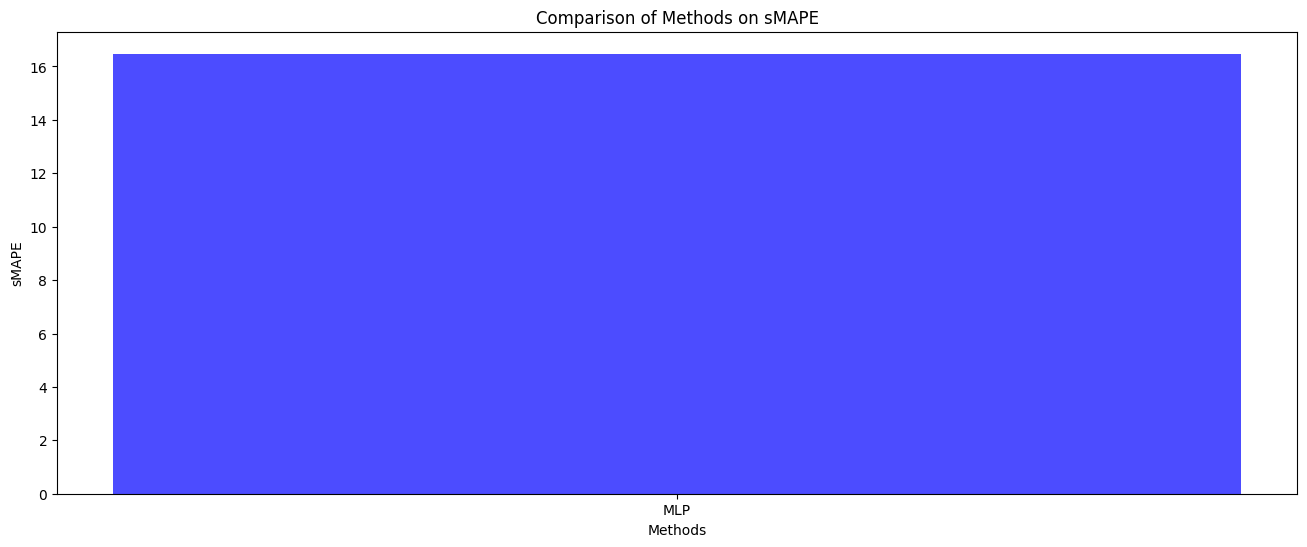

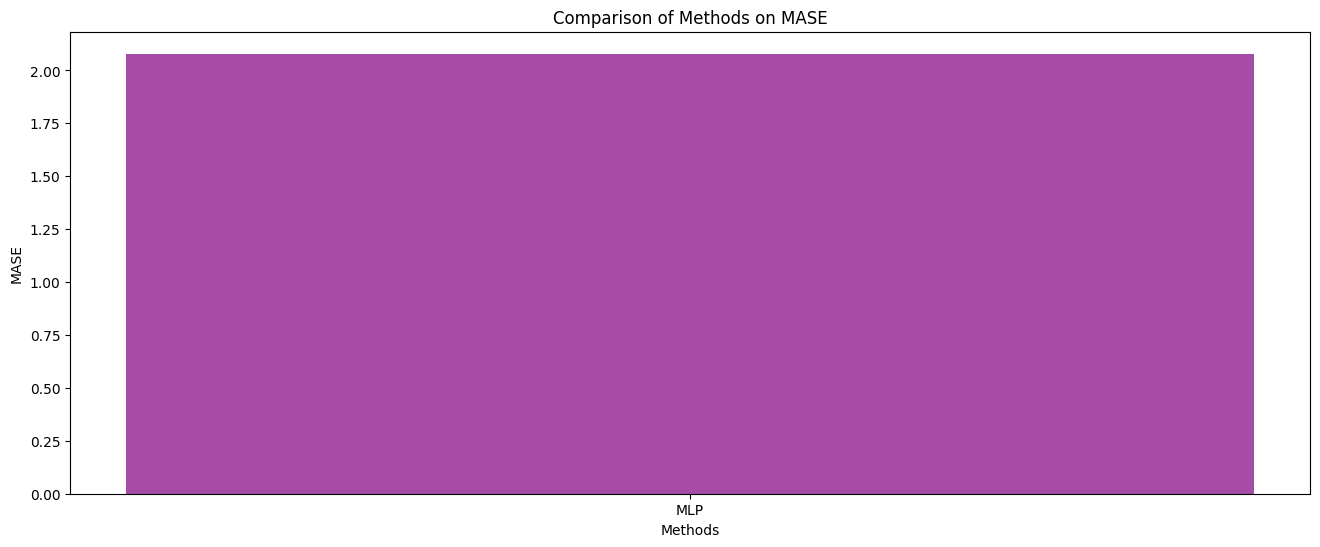

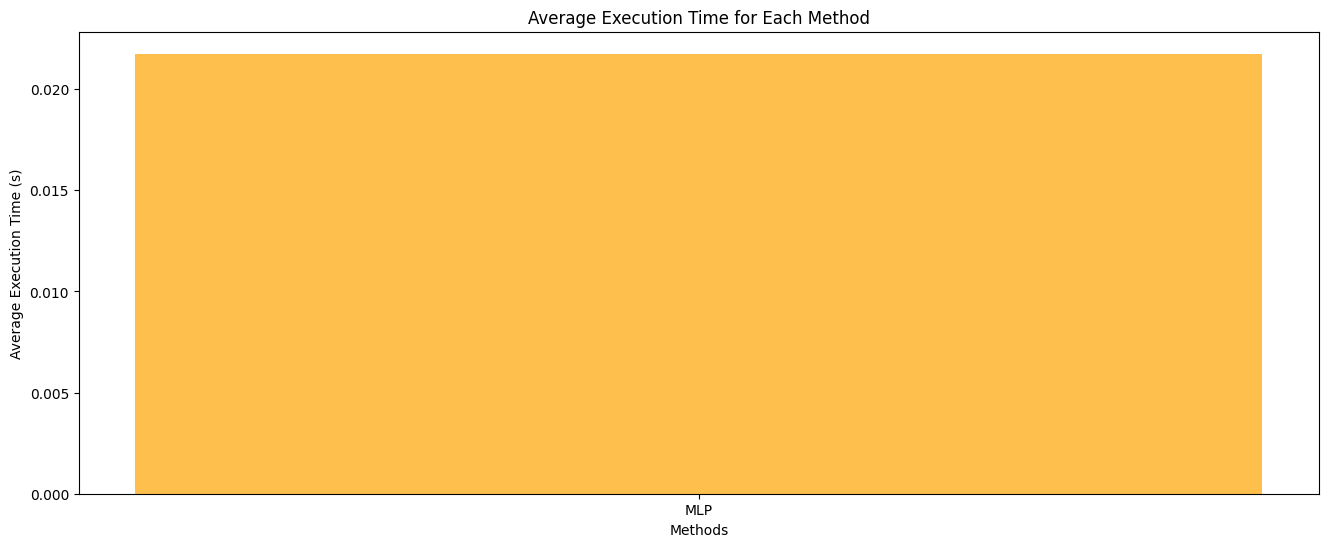

In [9]:
import matplotlib.pyplot as plt

methods_names = []
methods_smapes = []
methods_mases = []
methods_times = []
# methods_owas = []

for method, results in method_to_overall_res.items():
    methods_names.append(method)
    methods_smapes.append(results["sMAPE"])
    methods_mases.append(results["MASE"])
    methods_times.append(results["Avg Execution Time (s)"])
    # methods_owas.append(results['OWA'])

results_df = pd.DataFrame.from_dict(method_to_overall_res, orient="index")
figsize = (16, 6)

plt.figure(figsize=figsize)
plt.bar(methods_names, methods_smapes, color="b", alpha=0.7)
plt.xlabel("Methods")
plt.ylabel("sMAPE")
plt.title("Comparison of Methods on sMAPE")
plt.show()

plt.figure(figsize=figsize)
plt.bar(methods_names, methods_mases, color="purple", alpha=0.7)
plt.xlabel("Methods")
plt.ylabel("MASE")
plt.title("Comparison of Methods on MASE")
plt.show()

# plt.figure(figsize=figsize)
# plt.bar(methods_names, methods_owas, color='green', alpha=0.7)
# plt.xlabel('Methods')
# plt.ylabel('OWA')
# plt.title('Overall Weighted Average (OWA) for Each Method')
# plt.show()

plt.figure(figsize=figsize)
plt.bar(methods_names, methods_times, color="orange", alpha=0.7)
plt.xlabel("Methods")
plt.ylabel("Average Execution Time (s)")
plt.title("Average Execution Time for Each Method")
plt.show()

In [10]:
# def plot_real_vs_predicted_with_common_y_true(method_freq_results, freq_info):
#     """
#     Generate a plot for each frequency showing real vs predicted values using a common y_true.

#     Parameters:
#     - method_freq_results: Dictionary containing results per method and frequency.
#     - freq_info: Dictionary with information about frequencies.
#     """
#     # Extracting y_true from any available method (since it's common across methods)
#     example_method = next(iter(method_freq_results.values()))
#     common_y_true = {freq: results['Actual'].values for freq, results in example_method.items()}

#     for freq in freq_info.keys():
#         y_true = common_y_true[freq]  # Use the common actual values
#         train_series = next(iter(method_freq_results.values()))[freq].iloc[0]['TrainSeries'].values

#         plt.figure(figsize=(14, 6))
#         plt.plot(range(len(train_series)), train_series, label='Training Series', color='blue', alpha=0.6)
#         plt.plot(range(len(train_series), len(train_series) + len(y_true)), y_true, label='Actual', color='green')

#         for method_name, freq_results in method_freq_results.items():
#             y_pred = freq_results[freq]['Forecast'].values
#             plt.plot(range(len(train_series), len(train_series) + len(y_pred)), y_pred, label=f'{method_name} Forecast', linestyle='dashed')

#         plt.title(f'Real vs Predicted - Frequency: {freq}')
#         plt.xlabel('Time')
#         plt.ylabel('Value')
#         plt.legend()
#         plt.grid(True)
#         plt.show()

# # Generate plots with the common y_true for all methods
# plot_real_vs_predicted_with_common_y_true(method_to_freq_res, file_paths)